# **Set Up**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


In [ ]:
#import the file
from google.colab import files
uploaded = files.upload()


Saving vehicules.csv to vehicules.csv


In [ ]:
#read the data
data = pd.read_csv("vehicules.csv")

# **EDA & Feature Engeneering**

In [ ]:
#overview of the data
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [ ]:
# Removing the "instant" column as it is a simple count and does not provide useful information for prediction
data = data.drop(columns=["instant"])



In [ ]:
#convert column dteday to datetime dtype
data.dteday = pd.to_datetime(data.dteday, format = '%Y-%m-%d')
data['dteday'] = data['dteday'] + pd.to_timedelta(data['hr'], unit='h')
data.set_index('dteday', inplace=True)

In [ ]:
#checking for duplicates
data.duplicated().sum()

2

In [ ]:
#removing duplicates
data = data.drop_duplicates()
data.shape

(17377, 15)

In [ ]:
# Now onwards, we'll use the 'df' DataFrame for modeling purposes, this ensures that we have a separate DataFrame ('df') for manipulation without altering the original 'data' DataFrame

df = data.copy()  # Creating a copy of the original data for safe manipulation
df.head()         # Display the first few rows to verify the new DataFrame


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2011-01-01 01:00:00,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2011-01-01 02:00:00,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
2011-01-01 03:00:00,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
2011-01-01 04:00:00,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


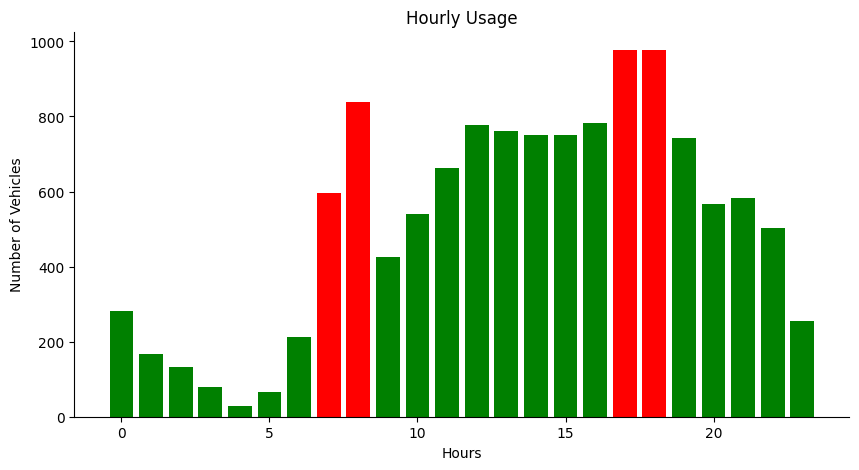

In [ ]:
#Plotting a graph of the hourly usage to understand the rush hours

# Define color mapping for the bars
colors = ['red' if hr in [7, 8, 17, 18] else 'green' for hr in data['hr']]

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(data['hr'], data['cnt'], color=colors)
ax.set_xlabel('Hours')
ax.set_ylabel('Number of Vehicles')
ax.set_title('Hourly Usage')

# Customize the appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.grid(False)  # Remove grid
ax.set_facecolor('white')  # Set background to white

plt.show()

Creating new features for ease of analysis

In [ ]:
# Define a function to classify rush hours for ease of usage during prediction, theses rush hours are assumed looking at graphs
def binRush(x):
    # Morning rush hour: 7 AM to 9 AM
    if 7 <= x < 9:
        return "Rush"
    # Evening rush hour: 5 PM to 7 PM
    elif 17 <= x < 19:
        return "Rush"
    # All other times are classified as "Not Rush"
    else:
        return "Not Rush"

# Apply the rush hour classification to the "hr" column and store the result in a new "Rush" column
df["Rush"] = df.apply(lambda x: binRush(x["hr"]), axis=1)


In [ ]:
# Define a function to classify wind speed for ease of usage during prediction
def binWind(x):
    # Low wind speed: below 0.1
    if x < 0.1:
        return "Low"
    # Medium wind speed: between 0.1 and 0.2
    elif 0.1 <= x < 0.2:
        return "Medium"
    # High wind speed: 0.2 and above
    else:
        return "High"

# Apply the wind speed classification to the "windspeed" column and store the result in a new "Wind" column
df["Wind"] = df.apply(lambda x: binWind(x["windspeed"]), axis=1)


In [ ]:
# Define a function to classify humidity levels for easier interpretation during prediction
def binHum(x):
    # Low humidity: below 0.3
    if x < 0.3:
        return "Low"
    # Medium humidity: between 0.31 and 0.6
    elif 0.31 <= x < 0.6:
        return "Medium"
    # High humidity: 0.6 and above
    else:
        return "High"

# Apply the humidity classification to the "hum" column and store the result in a new "Hum" column
df["Hum"] = df.apply(lambda x: binHum(x["hum"]), axis=1)


In [ ]:
# Create a new column for lagged counts by shifting the "cnt" column by 1 row.
# This adds the previous count as "prev_count" to help the model understand trends over time.
df["prev_count"] = df.cnt.shift(1)

# Drop any rows with missing values created by the shift, as the first row will have no previous count.
df = df.dropna()


# **Creating the model**

In [ ]:
!pip install pycaret

In [ ]:
#deleting columns from dataframe that are not adding any values to our forecast
df = df.drop(columns=["casual", "registered"])

In [ ]:
df.head(1)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,Rush,Wind,Hum,prev_count
dteday,,,,,,,,,,,,,,,,,
2011-01-01 01:00:00,1,0,1,1,0,6,0,1,0.22,0.2727,0.8,0.0,40,Not Rush,Low,High,16.0


In [ ]:
from pycaret.regression import *

# Setting up the PyCaret environment with specific configurations for time series data.
model = setup(
    data=df,
    target="cnt",  # Define target variable to predict

    # Specify column types
    categorical_features=["weekday", "season", "holiday", "workingday", "Rush", "Wind", "Hum", "hr", "mnth"],  # Define categorical columns
    numeric_features=['weathersit', 'temp'],  # Define numeric columns
    ignore_features=["yr", 'windspeed', 'prev_count', 'hum', 'atemp'],  # Ignore columns that aren't useful for modeling

    # Enable preprocessing options
    preprocess=True,  # Automatically preprocess data
    remove_multicollinearity=True,  # Remove features with high multicollinearity
    multicollinearity_threshold=0.7,  # Set threshold for multicollinearity removal
    feature_selection=False,  # Disable automatic feature selection

    # Configuring time series-specific settings
    fold_strategy="timeseries",  # Use time series splitting to preserve temporal order
    fold=3,  # Set the number of folds; fewer folds are often used in time series
    data_split_shuffle=False,  # Disable shuffling to preserve order during training/testing
    fold_shuffle=False,  # Ensure folds are not shuffled

    # Parallelization options
    n_jobs=-1,  # Use all available processors
    use_gpu=False  # Disable GPU usage
)


,Description,Value
0,Session id,181
1,Target,cnt
2,Target type,Regression
3,Original data shape,"(17376, 17)"
4,Transformed data shape,"(17376, 59)"
5,Transformed train set shape,"(12163, 59)"
6,Transformed test set shape,"(5213, 59)"
7,Ignore features,5
8,Numeric features,2
9,Categorical features,9


In [ ]:
#using xgboost as a model
clf = create_model('xgboost', fold = 5, round = 2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,67.15,9080.56,95.29,0.55,0.78,1.06
1,40.27,3747.93,61.22,0.83,0.64,0.85
2,47.75,4759.03,68.99,0.75,0.56,0.53
3,61.49,8098.01,89.99,0.46,0.82,0.81
4,98.14,17942.50,133.95,0.58,0.75,0.77
Mean,62.96,8725.61,89.89,0.63,0.71,0.81
Std,20.02,5019.60,25.41,0.14,0.09,0.17


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

- MAE (Mean Absolute Error): Mean of 62.96 indicates moderate average prediction error, with some variation across folds.
- MSE (Mean Squared Error): A high mean of 8725.61 suggests some large prediction errors, as squaring the errors amplifies their impact.
- RMSE (Root Mean Squared Error): 89.89 further confirms the presence of higher errors on average.
- R² (Coefficient of Determination): 0.63 shows that the model explains 63% of the variance in the data, a fair but not exceptional fit.
- RMSLE (Root Mean Squared Logarithmic Error): 0.71, suitable for datasets with potential outliers, suggests moderate error in log space.
- MAPE (Mean Absolute Percentage Error): 0.81 indicates an 81% average percentage error, pointing to substantial variability in predictions.

In [ ]:
# Importing the r2_score function from scikit-learn, which calculates the R-squared metric (coefficient of determination).
# This metric will be used to evaluate the model's performance, showing how well the model explains the variance in the target variable.
from sklearn.metrics import r2_score


In [ ]:
# Custom function to calculate a weighted R-squared metric
def weighted_r2(y, y_pred, **kwargs):
    # Calculates the proportion of predictions that are greater than or equal to the actual values
    positive_ratio = (y_pred >= y)
    # Returns the weighted R-squared, where the R-squared score is multiplied by the positive prediction ratio
    return positive_ratio.mean() * r2_score(y, y_pred)


In [ ]:
# Adding a custom metric to PyCaret's list of evaluation metrics
add_metric(
    id="weighted_r2",               # Unique identifier for the custom metric
    name="Weighted R2",              # Display name for the metric
    score_func=weighted_r2,          # Custom function to calculate the metric
    greater_is_better=True           # Indicates that higher values are better for this metric
)


,weighted_r2
Name,Weighted R2
Display Name,Weighted R2
Score Function,<function weighted_r2 at 0x7edd14bc28c0>
Scorer,"make_scorer(weighted_r2, response_method='pred..."
Target,pred
Args,{}
Greater is Better,True
Custom,True


In [ ]:
# Tuning the model to find the best hyperparameters based on the custom metric 'weighted_r2'
tuned_model = tune_model(
    clf,                         # Base model to be tuned
    optimize='weighted_r2',      # Metric to optimize during tuning
    fold=10                      # Number of cross-validation folds for evaluation
)


,MAE,MSE,RMSE,R2,RMSLE,MAPE,Weighted R2
Fold,,,,,,,
0,28.0248,1887.6833,43.4475,0.6992,0.7333,1.2420,0.3449
1,64.2737,7488.4555,86.5359,0.6103,0.8338,1.2722,0.2253
2,61.2076,6191.8242,78.6881,0.7362,0.8985,1.7751,0.3944
3,40.8444,3057.4102,55.2939,0.8518,0.6924,0.9989,0.5789
4,45.2303,4378.0295,66.1667,0.8076,0.5726,0.6257,0.2617
5,37.8011,2713.2667,52.0890,0.8516,0.6572,0.9505,0.5179
6,37.1593,3147.4324,56.1020,0.7419,0.6603,0.8629,0.3216
7,65.9614,8618.9446,92.8383,0.4792,0.7988,0.7258,0.0334
8,103.1192,20372.7698,142.7332,0.4648,0.7803,0.7969,0.0387


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
#finalizing the model
final_model = finalize_model(tuned_model)

In [ ]:
#extract the raw trained model from the PyCaret pipeline
raw_model = final_model.steps[-1][1]  #extracts the last step (the trained model)


In [ ]:
#save only the raw model using pickle
import pickle

In [ ]:
with open('my_vehicule_model.pkl', 'wb') as file:
    pickle.dump(raw_model, file)

In [ ]:
#verify the type of the raw model
print(type(raw_model))

<class 'xgboost.sklearn.XGBRegressor'>


In [ ]:
# Export the trained model file
from google.colab import files
files.download('my_vehicule_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>